In [ ]:
!pip install torch transformers datasets py7zr emoji spacy rouge_score nltk accelerate contractions
!python -m spacy download en_core_web_sm

# Verify GPU availability
import torch
print(f"GPU available: {torch.cuda.is_available()}")
print(f"GPU name: {torch.cuda.get_device_name(0)}")


  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 77.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 75.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 48.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 29.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 66.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 31.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.9/67.9 kB 5.3 MB/s eta 0:00:00
  

In [ ]:
import os
os.environ["WANDB_DISABLED"] = "true"  # Disable wandb completely

from huggingface_hub import HfApi, login
from transformers import TrainerCallback
class UploadToHubCallback(TrainerCallback):
    """Custom callback to upload model to HF Hub during training"""
    def __init__(self, hf_repo_name, token):
        self.hf_repo_name = hf_repo_name
        self.token = token
        self.api = HfApi()

    def on_save(self, args, state, control, **kwargs):
        """Upload model at each save point"""
        try:
            kwargs['model'].push_to_hub(
                self.hf_repo_name,
                use_auth_token=self.token,
                commit_message=f"Training checkpoint {state.global_step}"
            )
            print(f"Model uploaded to {self.hf_repo_name} at step {state.global_step}")
        except Exception as e:
            print(f"Failed to upload model: {str(e)}")

In [ ]:
import re
import emoji
import spacy
from typing import List, Tuple
from contractions import fix
import logging
import torch
from transformers import BartTokenizer, BartForConditionalGeneration, Trainer, TrainingArguments,AutoTokenizer
from datasets import load_dataset
from torch.utils.data import Dataset
import numpy as np
from google.colab import userdata


class DataCleaner:
    """
    Enhanced text cleaning processor with comprehensive text normalization
    """
    def __init__(self):
        self.logger = logging.getLogger(__name__ + '.DataCleaner')
        self.logger.setLevel(logging.INFO)

        try:
            self.nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])
            self.logger.info("spaCy English model loaded successfully")
        except OSError:
            self.logger.error("spaCy English model not found, downloading...")
            from spacy.cli import download
            download("en_core_web_sm")
            self.nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])

    def clean_text(self, text: str, intensive_cleaning: bool = True) -> str:
        """
        Unified cleaning method with configurable intensity
        """
        if not text or not isinstance(text, str):
            return ""

        # Common cleaning steps
        text = re.sub(r"<.*?>", "", text)  # Remove HTML tags
        text = re.sub(r"\\[rnt]", " ", text)  # Handle escaped chars
        text = re.sub(r"\s+", " ", text).strip()
        text = fix(text)  # Fix contractions and text artifacts

        if intensive_cleaning:
            text = text.lower()
            text = emoji.demojize(text)

            if len(text) < 1000:
                doc = self.nlp(text)
                text = " ".join([
                    token.lemma_
                    for token in doc
                    if not token.is_punct and not token.is_space
                ])

        return text

    def clean_dialogue(self, dialogue: str) -> str:
        """Alias for intensive cleaning"""
        return self.clean_text(dialogue, intensive_cleaning=True)

    def clean_summary(self, summary: str) -> str:
        """Alias for lighter cleaning"""
        return self.clean_text(summary, intensive_cleaning=False)

# Initialize logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s',
    handlers=[
        logging.FileHandler('text_cleaning.log'),
        logging.StreamHandler()
    ]
)

# Load and process dataset
def load_and_clean_dataset(dataset_name: str = "samsum") -> dict:
    cleaner = DataCleaner()
    dataset = load_dataset(dataset_name,trust_remote_code=True)

    def process_example(example):
        return {
            "dialogue": cleaner.clean_dialogue(example["dialogue"]),
            "summary": cleaner.clean_summary(example["summary"])
        }

    return dataset.map(process_example, batched=False)

# Tokenization and Model Training
class SummarizationDataset(Dataset):
    def __init__(self, tokenized_data):
        self.input_ids = tokenized_data["input_ids"]
        self.attention_mask = tokenized_data["attention_mask"]
        self.labels = tokenized_data["labels"]

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return {
            "input_ids": torch.tensor(self.input_ids[idx]),
            "attention_mask": torch.tensor(self.attention_mask[idx]),
            "labels": torch.tensor(self.labels[idx])
        }



In [ ]:

def fine_tune_bart(hf_token: str, hf_repo_name: str = "your-username/bart-samsum"):
    # Login to HF Hub
    login(token=hf_token)

    # Load and clean data
    dataset = load_and_clean_dataset()

    # Initialize model and tokenizer
    tokenizer = AutoTokenizer.from_pretrained("facebook/bart-large")
    model = BartForConditionalGeneration.from_pretrained("facebook/bart-large")

    # Tokenization function
    def tokenize_function(examples):
        inputs = tokenizer(
            examples["dialogue"],
            max_length=1024,
            truncation=True,
            padding="max_length"
        )

        with tokenizer.as_target_tokenizer():
            labels = tokenizer(
                examples["summary"],
                max_length=128,
                truncation=True,
                padding="max_length"
            )

        inputs["labels"] = labels["input_ids"]
        return inputs

    tokenized_data = dataset.map(tokenize_function, batched=True)

    # Training setup
    training_args = TrainingArguments(
        output_dir="./bart_finetuned",
        eval_strategy="epoch",
        learning_rate=3e-5,
        per_device_train_batch_size=4,
        per_device_eval_batch_size=4,
        weight_decay=0.01,
        save_total_limit=3,
        num_train_epochs=3,
        fp16=torch.cuda.is_available(),
        logging_dir="./logs",
        logging_steps=100,
        save_steps=1000,
        gradient_accumulation_steps=4,
        report_to="none",  # Disable all logging integrations
        push_to_hub=False,  # We'll handle this manually
    )

    # Create callback for HF uploads
    upload_callback = UploadToHubCallback(hf_repo_name, hf_token)

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=SummarizationDataset(tokenized_data["train"]),
        eval_dataset=SummarizationDataset(tokenized_data["test"]),
        callbacks=[upload_callback],
    )

    try:
        # Train and push final model
        trainer.train()

        # Push final model and tokenizer
        trainer.push_to_hub(
            commit_message="Training completed",
            blocking=True
        )
        print(f"Final model uploaded to {hf_repo_name}")
        tokenizer.push_to_hub(hf_repo_name)
        print(f"Tokenizer uploaded to {hf_repo_name}")

    except KeyboardInterrupt:
        print("\nTraining interrupted. Saving current progress...")
        # Push interrupted model
        trainer.push_to_hub(
            commit_message="Training interrupted",
            blocking=True
        )
        print(f"Interrupted model uploaded to {hf_repo_name}")

if __name__ == "__main__":
    # Get your HF token from https://huggingface.co/settings/tokens
    HF_TOKEN = userdata.get('HF_TOKEN')

    REPO_NAME = "bart-samsum"  # Format: username/repo-name

    fine_tune_bart(hf_token=HF_TOKEN, hf_repo_name=REPO_NAME)

INFO:__main__.DataCleaner:spaCy English model loaded successfully


README.md:   0%|          | 0.00/7.04k [00:00<?, ?B/s]

samsum.py:   0%|          | 0.00/3.36k [00:00<?, ?B/s]

corpus.7z:   0%|          | 0.00/2.94M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/14732 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/819 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/818 [00:00<?, ? examples/s]

Map:   0%|          | 0/14732 [00:00<?, ? examples/s]

Map:   0%|          | 0/819 [00:00<?, ? examples/s]

Map:   0%|          | 0/818 [00:00<?, ? examples/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.63k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.02G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.02G [00:00<?, ?B/s]

Map:   0%|          | 0/14732 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:3980: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/819 [00:00<?, ? examples/s]

Map:   0%|          | 0/818 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss
1,0.338000,0.313238
2,0.249000,0.301647


/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:3339: UserWarning: Moving the following attributes in the config to the generation config: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/utils/hub.py:920: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(


model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

Model uploaded to bart-samsum at step 1000


/usr/local/lib/python3.11/dist-packages/transformers/utils/hub.py:920: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(


README.md:   0%|          | 0.00/5.17k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

Failed to upload model: 500 Server Error: Internal Server Error for url: https://huggingface.co/api/models/Hashif/bart-samsum/commit/main (Request ID: Root=1-67fea759-513ed0b7495cc99f7c260d8a;18f25a90-fbaa-49cd-83e9-ad8d66d5e43e)

Internal Error - We're working hard to fix this as soon as possible!


/usr/local/lib/python3.11/dist-packages/transformers/utils/hub.py:920: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(


model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

Model uploaded to bart-samsum at step 2760


Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/5.24k [00:00<?, ?B/s]

Final model uploaded to bart-samsum


In [ ]:
tokenizer = AutoTokenizer.from_pretrained("facebook/bart-large")
tokenizer.push_to_hub("bart-samsum")


CommitInfo(commit_url='https://huggingface.co/Hashif/bart-samsum/commit/fca670d9d2bd852e30f46a272da5646b1971ef6b', commit_message='Upload tokenizer', commit_description='', oid='fca670d9d2bd852e30f46a272da5646b1971ef6b', pr_url=None, repo_url=RepoUrl('https://huggingface.co/Hashif/bart-samsum', endpoint='https://huggingface.co', repo_type='model', repo_id='Hashif/bart-samsum'), pr_revision=None, pr_num=None)

In [ ]:
from transformers import pipeline
from datasets import load_dataset
import torch

# 1. Load your fine-tuned model
model_name = "Hashif/bart-samsum"  # Replace with your HF repo name
summarizer = pipeline(
    "summarization",
    model=model_name,
    tokenizer=model_name,
    device=0 if torch.cuda.is_available() else -1
)
cleaner = DataCleaner()
dataset = load_dataset("samsum", split="validation")

def process_example(example):
    return {
        "original_dialogue": example["dialogue"],
        "cleaned_dialogue": cleaner.clean_text(example["dialogue"]),
        "reference_summary": example["summary"]
    }

cleaned_data = dataset.map(process_example)


for example in cleaned_data.select(range(3)):  # First 3 examples
    print("\n=== Original Dialogue ===")
    print(example["original_dialogue"])

    print("\n=== Cleaned Dialogue ===")
    print(example["cleaned_dialogue"])

    result = summarizer(example["cleaned_dialogue"],
                      max_length=128,
                      min_length=30,
                      num_beams=4)

    print("\n=== Generated Summary ===")
    print(result[0]['summary_text'])

    print("\n=== Reference Summary ===")
    print(example["reference_summary"])
    print("-"*50)

tokenizer_config.json:   0%|          | 0.00/1.24k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.56M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/279 [00:00<?, ?B/s]

Device set to use cuda:0
INFO:__main__.DataCleaner:spaCy English model loaded successfully



=== Original Dialogue ===
A: Hi Tom, are you busy tomorrow’s afternoon?
B: I’m pretty sure I am. What’s up?
A: Can you go with me to the animal shelter?.
B: What do you want to do?
A: I want to get a puppy for my son.
B: That will make him so happy.
A: Yeah, we’ve discussed it many times. I think he’s ready now.
B: That’s good. Raising a dog is a tough issue. Like having a baby ;-) 
A: I'll get him one of those little dogs.
B: One that won't grow up too big;-)
A: And eat too much;-))
B: Do you know which one he would like?
A: Oh, yes, I took him there last Monday. He showed me one that he really liked.
B: I bet you had to drag him away.
A: He wanted to take it home right away ;-).
B: I wonder what he'll name it.
A: He said he’d name it after his dead hamster – Lemmy  - he's  a great Motorhead fan :-)))

=== Cleaned Dialogue ===
a hi tom be you busy tomorrow ’s afternoon b I be pretty sure I be what be up a can you go with I to the animal shelter b what do you want to do a I want to ge

In [ ]:
import json
with open('./bart_finetuned/checkpoint-2760/trainer_state.json') as f:
    logs = json.load(f)

print("All metrics:", logs['log_history'])

All metrics: [{'epoch': 0.10860711376595167, 'grad_norm': 33.09113693237305, 'learning_rate': 2.8956521739130434e-05, 'loss': 5.7819, 'step': 100}, {'epoch': 0.21721422753190334, 'grad_norm': 3.0474295616149902, 'learning_rate': 2.7880434782608697e-05, 'loss': 0.8455, 'step': 200}, {'epoch': 0.325821341297855, 'grad_norm': 1.419948935508728, 'learning_rate': 2.6793478260869566e-05, 'loss': 0.4045, 'step': 300}, {'epoch': 0.4344284550638067, 'grad_norm': 1.3715236186981201, 'learning_rate': 2.5706521739130436e-05, 'loss': 0.3852, 'step': 400}, {'epoch': 0.5430355688297583, 'grad_norm': 1.8231626749038696, 'learning_rate': 2.4619565217391306e-05, 'loss': 0.3704, 'step': 500}, {'epoch': 0.65164268259571, 'grad_norm': 1.5783699750900269, 'learning_rate': 2.3543478260869565e-05, 'loss': 0.3707, 'step': 600}, {'epoch': 0.7602497963616617, 'grad_norm': 1.196558952331543, 'learning_rate': 2.2456521739130435e-05, 'loss': 0.3565, 'step': 700}, {'epoch': 0.8688569101276133, 'grad_norm': 1.3011180

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Convert logs to DataFrame
metrics = pd.DataFrame([
    {**d, 'phase': 'train'} if 'loss' in d else {**d, 'phase': 'eval'}
    for d in logs['log_history']
])

# Separate training and validation metrics
train_metrics = metrics[metrics['phase'] == 'train'].copy()
eval_metrics = metrics[metrics['phase'] == 'eval'].copy()

# Calculate steps per epoch
steps_per_epoch = train_metrics['step'].max() / train_metrics['epoch'].max()

In [ ]:
# Print important metrics
print("=== Training Summary ===")
print(f"Final Training Loss: {train_metrics['loss'].iloc[-1]:.4f}")
print(f"Best Validation Loss: {eval_metrics['eval_loss'].min():.4f}")
print(f"Training Steps: {len(train_metrics)}")
print(f"Epochs Completed: {eval_metrics['epoch'].max():.1f}")
print(f"Final Learning Rate: {train_metrics['learning_rate'].iloc[-1]:.2e}")
print("\nEpoch-wise Validation Loss:")
print(eval_metrics[['epoch', 'eval_loss']].to_string(index=False))

=== Training Summary ===
Final Training Loss: 0.2490
Best Validation Loss: 0.3027
Training Steps: 27
Epochs Completed: 2.0
Final Learning Rate: 7.17e-07

Epoch-wise Validation Loss:
 epoch  eval_loss
   1.0   0.313238
   2.0   0.302661


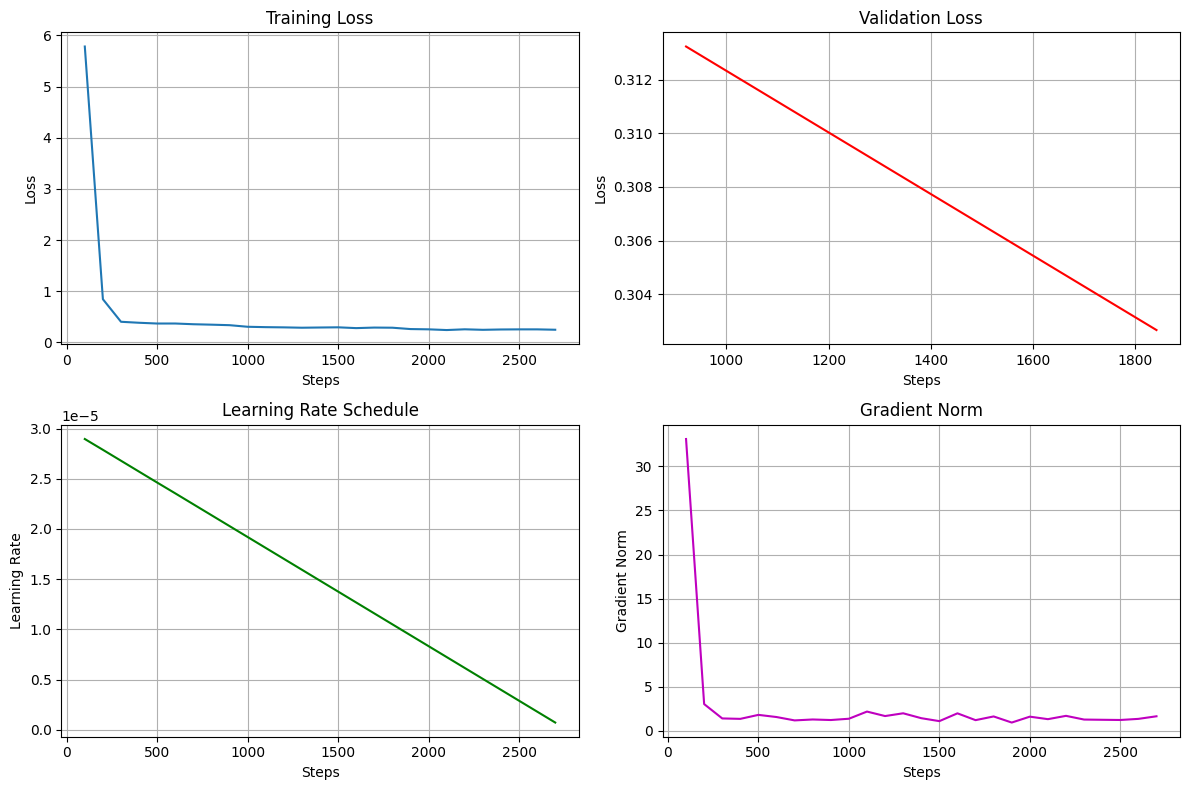

In [ ]:
plt.figure(figsize=(12, 8))

# Plot Training Loss
plt.subplot(2, 2, 1)
plt.plot(train_metrics['step'], train_metrics['loss'], label='Training Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.grid(True)

# Plot Validation Loss
plt.subplot(2, 2, 2)
plt.plot(eval_metrics['step'], eval_metrics['eval_loss'], 'r-', label='Validation Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.title('Validation Loss')
plt.grid(True)

# Plot Learning Rate
plt.subplot(2, 2, 3)
plt.plot(train_metrics['step'], train_metrics['learning_rate'], 'g-')
plt.xlabel('Steps')
plt.ylabel('Learning Rate')
plt.title('Learning Rate Schedule')
plt.grid(True)

# Plot Gradient Norm
plt.subplot(2, 2, 4)
plt.plot(train_metrics['step'], train_metrics['grad_norm'], 'm-')
plt.xlabel('Steps')
plt.ylabel('Gradient Norm')
plt.title('Gradient Norm')
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
# Convergence Analysis
final_window = 200  # Last N steps
conv_rate = (train_metrics['loss'].iloc[-final_window:-1].pct_change().mean() * 100)
print(f"\nConvergence Rate (last {final_window} steps): {conv_rate:.2f}% per step")

# Training Efficiency
avg_samples_sec = eval_metrics['eval_samples_per_second'].mean()
print(f"\nAverage Inference Speed: {avg_samples_sec:.1f} samples/sec")

# Loss Reduction
initial_loss = train_metrics['loss'].iloc[0]
final_loss = train_metrics['loss'].iloc[-1]
print(f"\nTotal Loss Reduction: {initial_loss-final_loss:.2f} ({((initial_loss-final_loss)/initial_loss*100):.1f}%)")


Convergence Rate (last 200 steps): -7.25% per step

Average Inference Speed: 100.3 samples/sec

Total Loss Reduction: 5.53 (95.7%)


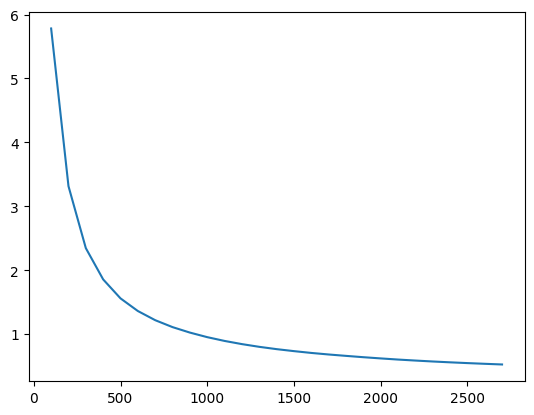